<a href="https://colab.research.google.com/github/hucarlos08/Nerf-Geo/blob/main/PreNerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis

The idea proposed in the paper [**NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis**](https://arxiv.org/abs/2003.08934) aims to generate new views of an object (or even better, of a scene) using deep learning and computer graphics concepts. To better understand the idea, we first need to understand how information is captured in an image ([Ref](https://www.cambridge.org/core/books/multiple-view-geometry-in-computer-vision/0B6F289C78B2B23F596CAA76D3D43F7A)).


## Introduction: The 3D Revolution and Its Neural Future

In a world where 3D models are becoming as ubiquitous as 2D images, understanding how we represent and interact with three-dimensional spaces is more critical than ever. From designing complex machinery in CAD software to simulating the behavior of structures under stress, or even immersing ourselves in virtual and augmented reality experiences, 3D representation is the backbone of countless engineering applications.

But traditional methods for representing 3D objects, like meshes and point clouds, have their limitations. They can be cumbersome, computationally expensive, and struggle to capture the nuances of complex shapes and scenes. This is where Neural Radiance Fields (NeRF), a groundbreaking approach leveraging the power of neural networks, steps in.

NeRF has revolutionized the way we think about 3D representation, offering a more flexible, efficient, and photorealistic way to capture and recreate the world around us. In this notebook, we'll embark on a journey to understand the core concepts that underpin this exciting technology. We'll start with the fundamentals of 3D representation, explore how cameras capture light, delve into the magic of rendering, and get a taste of the incredible capabilities of neural networks. By the end, you'll have a solid grasp of the key ideas that make NeRF tick, setting the stage for deeper exploration into its technical intricacies.

So, buckle up and get ready to dive into the fascinating world of 3D representation and its neural future!

**In this notebook, we'll cover the following:**

1. **Representing the 3D World:** Exploring different ways to represent objects in 3D.
2. **Capturing Light: The Pinhole Camera Model:** Understanding how cameras capture 3D scenes.
3. **Generating Images: Rendering:** Learning how to create images from 3D data.
4. **Neural Networks: Our Universal Tool:** Discovering the power of neural networks for complex tasks.
5. **View Synthesis: The NeRF Challenge:**  Understanding the problem NeRF solves and how it differs from traditional methods.
6. **NeRF Sneak Peek:** A glimpse into the inner workings and incredible results of NeRF.




### 1. Representing the 3D World: Beyond Lines and Dots

In the digital realm, representing three-dimensional objects accurately and efficiently is a fundamental challenge. Engineering applications, from CAD modeling to virtual reality simulations, rely heavily on our ability to capture and manipulate 3D data. Let's explore some common ways to represent 3D objects and their trade-offs:

**1.1 Meshes: Connecting the Dots**

[Image of a 3D mesh model, showing triangles and vertices]

* **The Concept:** Imagine wrapping a wireframe around an object, forming a network of interconnected triangles. Each triangle is defined by three points called vertices, and the entire collection of triangles forms a mesh.
* **Applications:** Meshes are widely used in computer graphics and engineering due to their flexibility and ability to represent complex shapes.
* **Limitations:**
    * **Sharpness:** Meshes struggle to represent sharp edges or fine details accurately, requiring many tiny triangles.
    * **Complexity:** Complex models can have millions of triangles, making them computationally expensive to manipulate.

**1.2 Point Clouds: A Scattered Representation**

[Image of a 3D point cloud model]

* **The Concept:** A point cloud is simply a collection of points in 3D space, each with coordinates (x, y, z). Imagine a swarm of fireflies representing the surface of an object.
* **Applications:** Point clouds are often generated from LiDAR (Light Detection and Ranging) scans, which measure distances to objects using lasers.
* **Limitations:**
    * **No Connectivity:** Point clouds lack information about how points are connected, making it difficult to distinguish the object's surface from empty space.
    * **Rendering:** Creating realistic images from point clouds is challenging due to the lack of surface information.

**1.3 Volumetric Representation: Filling the Space**



* **The Concept:**  Imagine dividing 3D space into tiny cubes called voxels (like 3D pixels). Each voxel stores information about the density and color of the material it represents.
* **Advantages:**
    * **Continuous:** Volumetric representations capture the continuous nature of real-world objects, unlike discrete meshes or points.
    * **Implicit Surfaces:**  We can define surfaces implicitly as regions where density crosses a certain threshold.
* **Relevance to NeRF:** Neural Radiance Fields leverage this volumetric representation, learning the density and color of each point in space. This allows for incredibly detailed and realistic 3D scenes.

In the next sections, we'll delve deeper into how we capture light from these 3D representations and use it to generate images. Stay tuned!


## Camera Model
We can see three coordinate frames:
1. World
2. Camera
3. Image

The idea is to understand how to perform transformations between each of the frames.

| ![2d-train](https://imgur.com/EvLTR2w.png) |
| :---: |
| **Figure 1**: Camera model. |


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define camera parameters (you'll need to adjust these)
focal_length = 50  # In pixels
image_width = 640
image_height = 480

# Define camera pose (rotation and translation)
# Rotation matrix (Euler angles example, you might use quaternions or other representations)
theta_x = np.radians(30)  # Rotation around X axis
theta_y = np.radians(15)  # Rotation around Y axis
theta_z = np.radians(0)   # Rotation around Z axis

R_x = np.array([[1, 0, 0],
                [0, np.cos(theta_x), -np.sin(theta_x)],
                [0, np.sin(theta_x), np.cos(theta_x)]])
R_y = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                [0, 1, 0],
                [-np.sin(theta_y), 0, np.cos(theta_y)]])
R_z = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])
R = R_z @ R_y @ R_x  # Combined rotation matrix

# Translation vector
T = np.array([-2, 1, 5])  # Camera position in the world

# Combine rotation and translation into a transformation matrix
P = np.hstack((R, T.reshape(-1, 1)))
P = np.vstack((P, [0, 0, 0, 1]))  # Homogeneous coordinates


# Define a point in the world coordinate frame
X_w = np.array([3, 2, 10, 1])  # Homogeneous coordinates (x, y, z, 1)

# Transform to camera coordinates
X_c = P @ X_w

# Project to image plane (assuming pinhole camera model)
x = focal_length * X_c[0] / X_c[2] + image_width / 2
y = focal_length * X_c[1] / X_c[2] + image_height / 2

print("World coordinates:", X_w[:3])
print("Camera coordinates:", X_c[:3])
print("Projected image coordinates (pixels):", x, y)


World coordinates: [ 3  2 10]
Camera coordinates: [ 3.3980352  -2.26794919 13.55463173]
Projected image coordinates (pixels): 332.5345906568614 231.6340434846119


## From World to Camera

### World Coordinates
We usually represent the **world** coordinates using a vector $\mathbf{X}_w\in\mathbb{R}^3$ defined as:
$$
\mathbf{X}_w=\begin{bmatrix}
x_w \\
y_w \\
z_w
\end{bmatrix}
$$.

### Camera Coordinates
This is a dynamic reference frame that moves as we move the camera to take pictures. If a point $P$ has coordinates $\mathbf{X}_w$ in the *world frame*, in the **camera frame** we assign the coordinates:
$$
\mathbf{X}_c=\begin{bmatrix}
x_c \\
y_c \\
z_c
\end{bmatrix}
$$

**The location of point $P$ does not change. Only the way we look at the point changes with the change in the camera's reference frame.**

### Coordinate Transformation
It is possible to transform the coordinates of point $P$ from world to camera using the following equation:
$$
\mathbf{X}_c=R\times(\mathbf{X}_w-\mathbf{C}_w),
$$
where:
1. $R$ is a matrix representing the **orientation** of the camera with respect to the *world* coordinates.
2. $\mathbf{C}_w$ is a vector representing the **position** of the camera with respect to the *world* coordinates.

The matrix $C_{ext}$ is known as **extrinsic parameter matrix** because it represents the rotation and translation values, which are external properties of the camera.


## Image Formation

Let's return to the reference frames of the camera and the image

| ![2d-train](https://imgur.com/GCMmOLa.png) |
| :---: |
| **Figure 1**: Modelo proyectivo. |


### Projection to Image Plane
The projection to the image plane is done using the intrinsic parameters of the camera. If a point $P$ has coordinates $\mathbf{X}_c$ in the camera frame, its projection onto the image plane is given by:
$$
\begin{align}
x_i=f\frac{x_c}{z_c} \\
y_i=f\frac{y_c}{z_c}
\end{align}
$$
It is common for the image origin to be the top-left corner, so it is convenient to add offsets with respect to the image plane center:
$$
\begin{align}
x_i=f\frac{x_c}{z_c}+\delta_x \\
y_i=f\frac{y_c}{z_c}+\delta_y
\end{align}
$$
We can rewrite the previous equations as:
\begin{equation}
\begin{bmatrix}
fx_c+ z_c\delta_x\\
fy_c+ z_c\delta_y\\
~z_c\\
\end{bmatrix}=
\begin{bmatrix}
f_x&0&\delta_x&0\\
0&f_y&\delta_y&0\\
0&0&1&0\\
\end{bmatrix} \begin{bmatrix}
x_{c}\\
y_{c}\\
z_{c}\\
1\\
\end{bmatrix}
\tag{3}
\end{equation}
The first matrix on the right-hand side of the equation is known as the intrinsic parameters matrix $K$. It is termed intrinsic because it includes the focal length $f$ and the image plane center, which are internal properties of the camera.


Images shape: (106, 100, 100, 3)
Poses shape: (106, 4, 4)
Focal length: 138.88887889922103
Pose
[[ 7.9563183e-01  5.2092606e-01 -3.0920234e-01 -1.2464346e+00]
 [-6.0578054e-01  6.8418401e-01 -4.0610620e-01 -1.6370665e+00]
 [-1.4901161e-08  5.1041979e-01  8.5992539e-01  3.4664700e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


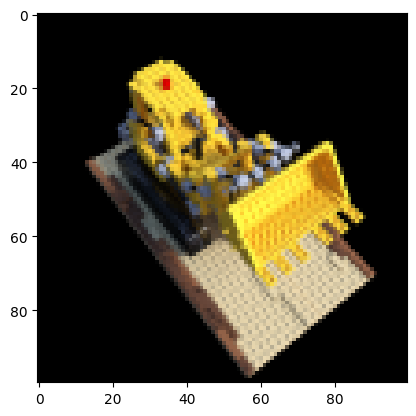

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

print(f'Images shape: {images.shape}')
print(f'Poses shape: {poses.shape}')
print(f'Focal length: {focal}')

height, width = images.shape[1:3]

testimg_idx = 3
testimg, testpose = images[testimg_idx], poses[testimg_idx]

plt.imshow(testimg)
print('Pose')
print(testpose)


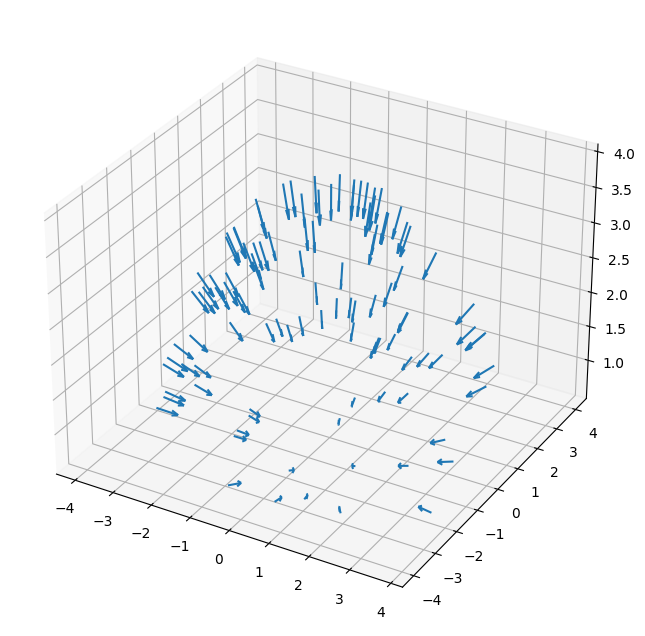

In [2]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_  = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=True)
plt.show()
